# Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# change to your working directory
#%cd "/content/drive/MyDrive/shared folder/Master_Thesis"
%cd "/content/drive/MyDrive/shared_folder/Master_Thesis" 

/content/drive/.shortcut-targets-by-id/1lHcON5EHJDerZlJ2mPUGsY4w6iFLBKs5/shared_folder/Master_Thesis


In [ ]:
!pip install adapt

In [ ]:
import os, random, shutil, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image

from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise 
from tensorflow.keras.layers import BatchNormalization,  GlobalMaxPooling2D, GlobalAveragePooling2D,  Add
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, ResNet50V2, MobileNetV3Large
from tensorflow.keras.constraints import MinMaxNorm, MaxNorm
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

from adapt.parameter_based import FineTuning
from adapt.feature_based import MDD
from adapt.utils import UpdateLambda

In [ ]:
print("GPU Available: ", tf.test.is_gpu_available())
print(tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
2.8.0


In [ ]:
# Original Dataset
Source_dir_train1 = "./Images/DANN/Source/LC25000_mix_data_128_train1.pkl"
Source_dir_train2 = "./Images/DANN/Source/LC25000_mix_data_128_train2.pkl"
Source_dir_train3 = "./Images/DANN/Source/LC25000_mix_data_128_train3.pkl"
Source_dir_train4 = "./Images/DANN/Source/LC25000_mix_data_128_train4.pkl"
Source_dir_train5 = "./Images/DANN/Source/LC25000_mix_data_128_train5.pkl"
Source_dir_test1 = "./Images/DANN/Source/LC25000_mix_data_128_test1.pkl"
Source_dir_test2 = "./Images/DANN/Source/LC25000_mix_data_128_test2.pkl"


Target_dir_train = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_128_train.pkl")
Target_dir_test = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_128_test.pkl")

# Cyclegan Dataset

Target_cyclegan_dir_train = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_128_train.pkl")
Target_cyclegan_dir_test = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_128_test.pkl")

In [ ]:
BATCH_SIZE = 64
CHANNELS = 3
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
EPOCH = 5

# Loading Dataset

## LC25000 Dataset

In [ ]:
# LC25000 Dataset
with open(os.path.abspath(Source_dir_train1), "rb") as f:
    LC25000_train1 = pickle.load(f)
with open(os.path.abspath(Source_dir_train2), "rb") as f:
    LC25000_train2 = pickle.load(f)
with open(os.path.abspath(Source_dir_train3), "rb") as f:
    LC25000_train3 = pickle.load(f)
with open(os.path.abspath(Source_dir_train4), "rb") as f:
    LC25000_train4 = pickle.load(f)
with open(os.path.abspath(Source_dir_train5), "rb") as f:
    LC25000_train5 = pickle.load(f)
with open(os.path.abspath(Source_dir_test1), "rb") as f:
    LC25000_test1 = pickle.load(f)
with open(os.path.abspath(Source_dir_test2), "rb") as f:
    LC25000_test2 = pickle.load(f)

In [ ]:
LC25000_train_data = LC25000_train1['train'] + LC25000_train2['train'] + LC25000_train3['train'] + LC25000_train4['train'] + LC25000_train5['train']
LC25000_train_labels = np.concatenate((LC25000_train1['train_label'],LC25000_train2['train_label'],LC25000_train3['train_label'],LC25000_train4['train_label'],LC25000_train5['train_label']))
LC25000_test_data = LC25000_test1['test'] + LC25000_test2['test']
LC25000_test_labels = np.concatenate((LC25000_test1['test_label'],LC25000_test2['test_label']))

In [ ]:
LC25000_train_lab = tf.one_hot(LC25000_train_labels, depth=3)
LC25000_test_lab = tf.one_hot(LC25000_test_labels, depth=3)
LC25000_train_data = np.array(LC25000_train_data, dtype=np.float32)
LC25000_test_data = np.array(LC25000_test_data, dtype=np.float32)

In [ ]:
print("The shape of LC25000_train_data: ", np.shape(LC25000_train_data))
print("The shape of LC25000_train_labels: ", np.shape(LC25000_train_labels))
print("The shape of LC25000_test_data: ", np.shape(LC25000_test_data))
print("The shape of LC25000_test_labels: " ,np.shape(LC25000_test_labels))

The shape of LC25000_train_data:  (6400, 128, 128, 3)
The shape of LC25000_train_labels:  (6400,)
The shape of LC25000_test_data:  (1600, 128, 128, 3)
The shape of LC25000_test_labels:  (1600,)


In [ ]:
import gc
gc.collect()

222

## TCGA Dataset

In [ ]:
# TCGA Dataset
with open(os.path.abspath(Target_dir_train), "rb") as f:
    TCGA_train = pickle.load(f)
with open(os.path.abspath(Target_dir_test), "rb") as f:
    TCGA_test = pickle.load(f)

In [ ]:
TCGA_train_data = TCGA_train['train']
TCGA_train_labels = TCGA_train['train_label']
TCGA_test_data = TCGA_test['test']
TCGA_test_labels = TCGA_test['test_label']

In [ ]:
TCGA_train_lab = tf.one_hot(TCGA_train_labels, depth=3)
TCGA_test_lab = tf.one_hot(TCGA_test_labels, depth=3)
TCGA_train_data = np.array(TCGA_train_data, dtype=np.float32)
TCGA_test_data = np.array(TCGA_test_data, dtype=np.float32)

In [ ]:
print("The shape of TCGA_train_data: ", np.shape(TCGA_train_data))
print("The shape of TCGA_train_labels: ", np.shape(TCGA_train_labels))
print("The shape of TCGA_test_data: ", np.shape(TCGA_test_data))
print("The shape of TCGA_test_labels: " , np.shape(TCGA_test_labels))

The shape of TCGA_train_data:  (6400, 128, 128, 3)
The shape of TCGA_train_labels:  (6400,)
The shape of TCGA_test_data:  (6400, 128, 128, 3)
The shape of TCGA_test_labels:  (6400,)


In [ ]:
import gc
gc.collect()

203

## Datasets Visualization

<function matplotlib.pyplot.show>

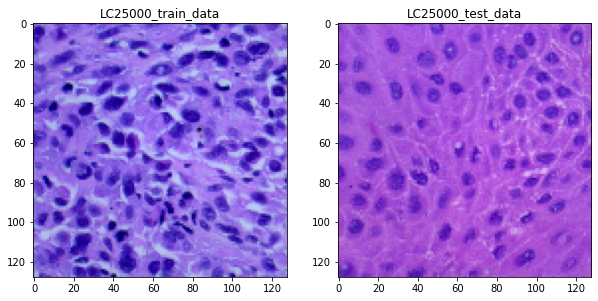

In [ ]:
# random show source images
fig = plt.subplots(1,2,figsize=(10,10))
#plt.suptitle("Source Domain = LC25000", fontsize=18)
ax1=plt.subplot(1,2,1)
sample1 = random.choice(LC25000_train_data)
img1 = array_to_img(sample1)
plt.show
plt.title("LC25000_train_data")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(LC25000_test_data)
img2 = array_to_img(sample2)
plt.title("LC25000_test_data")
plt.imshow(img2)
plt.show

<function matplotlib.pyplot.show>

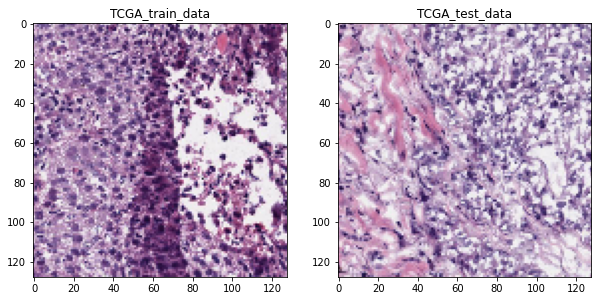

In [ ]:
# random show Target images
plt.subplots(1,2,figsize=(10,10))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(TCGA_train_data)
img1 = array_to_img(sample1)
plt.title("TCGA_train_data")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(TCGA_test_data)
img2 = array_to_img(sample2)
plt.title("TCGA_test_data")
plt.imshow(img2)
plt.show

In [ ]:
#LC25000_train_data, LC25000_train_labels, TCGA_train_data, TCGA_train_labels

# Domain Adaptation

## Build Model

### Feature Extractor - VGG

In [ ]:
vgg =  VGG16(include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), pooling="max")

first_layer = vgg.get_layer('block4_pool')
inputs = Input(first_layer.output_shape[1:])

# for layer in vgg.layers[vgg.layers.index(first_layer)+1:]:
#     x = layer(inputs)

for layer in vgg.layers[vgg.layers.index(first_layer)+1:]:
    if layer.name == "block5_conv1":
        x = layer(inputs)
    else:
        x = layer(x)
    # x = layer(inputs)

first_blocks = Model(vgg.input, first_layer.output)
last_block = Model(inputs, x)

In [ ]:
def load_vgg(path="./Model/DANN_Model/vgg_last_block_128.hdf5"):
    model = load_model(path)
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

last_block.summary()
last_block.save("./Model/DANN_Model/vgg_last_block_128.hdf5")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8, 8, 512)]       0         
                                                                 
 block5_conv1 (Conv2D)       (None, 8, 8, 512)         2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 8, 8, 512)         2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 8, 8, 512)         2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 4, 4, 512)         0         
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                           

### Extract the features 

In [ ]:
LC25000_train_data_ex = first_blocks.predict(preprocess_input(np.stack(LC25000_train_data)))
TCGA_train_data_ex = first_blocks.predict(preprocess_input(np.stack(TCGA_train_data)))

# one = OneHotEncoder(sparse=False)
# one.fit(np.array(LC25000_train_labels).reshape(-1, 1))

# LC25000_train_lab = one.transform(np.array(LC25000_train_labels).reshape(-1, 1))
# TCGA_train_lab = one.transform(np.array(TCGA_train_labels).reshape(-1, 1))

print("LC25000_train_data (source) shape: %s"%str(LC25000_train_data.shape))
print("TCGA_train_data (target) shape: %s"%str(TCGA_train_data.shape))

LC25000_train_data (source) shape: (6400, 128, 128, 3)
TCGA_train_data (target) shape: (6400, 128, 128, 3)


### Label Predictor

In [ ]:
def get_task(dropout=0.5, max_norm=0.5):
    model = Sequential()
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation="softmax",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    return model

In [ ]:
class MyDecay(LearningRateSchedule):

    def __init__(self, max_steps=1000, mu_0=0.01, alpha=10, beta=0.75):
        self.mu_0 = mu_0
        self.alpha = alpha
        self.beta = beta
        self.max_steps = float(max_steps)

    def __call__(self, step):
        p = step / self.max_steps
        return self.mu_0 / (1+self.alpha * p)**self.beta

# Fit without adaptation

### Run 1

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
100/100 [==============================] - 6s 37ms/step - loss: 0.9352 - acc: 0.7959 - val_loss: 1.7590 - val_acc: 0.4400
Epoch 2/5
100/100 [==============================] - 3s 30ms/step - loss: 0.3249 - acc: 0.9034 - val_loss: 2.0392 - val_acc: 0.4369
Epoch 3/5
100/100 [==============================] - 3s 30ms/step - loss: 0.2563 - acc: 0.9214 - val_loss: 2.6943 - val_acc: 0.4216
Epoch 4/5
100/100 [==============================] - 3s 30ms/step - loss: 0.2201 - acc: 0.9322 - val_loss: 3.0303 - val_acc: 0.4087
Epoch 5/5
100/100 [==============================] - 3s 28ms/step - loss: 0.2199 - acc: 0.9320 - val_loss: 3.2163 - val_acc: 0.4202
Epoch 1/100
100/100 [==============================] - 7s 46ms/step - loss: 0.1971 - acc: 0.9316 - val_loss: 2.9150 - val_acc: 0.4472
Epoch 2/100
100/100 [==============================] - 4s 38ms/step - loss: 0.1574 - acc: 0.9448 - val_loss: 3.2056 - val_acc: 0.4523
Epoch 3/100
100/100 [==============================] - 4s 39ms/step - lo

### Run 2

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
100/100 [==============================] - 5s 25ms/step - loss: 1.1119 - acc: 0.7781 - val_loss: 1.4169 - val_acc: 0.4500
Epoch 2/5
100/100 [==============================] - 2s 20ms/step - loss: 0.3078 - acc: 0.9070 - val_loss: 1.9160 - val_acc: 0.4444
Epoch 3/5
100/100 [==============================] - 2s 20ms/step - loss: 0.2447 - acc: 0.9230 - val_loss: 2.2520 - val_acc: 0.4495
Epoch 4/5
100/100 [==============================] - 2s 21ms/step - loss: 0.2300 - acc: 0.9294 - val_loss: 2.3223 - val_acc: 0.4414
Epoch 5/5
100/100 [==============================] - 2s 20ms/step - loss: 0.2146 - acc: 0.9295 - val_loss: 2.8291 - val_acc: 0.4403
Epoch 1/100
100/100 [==============================] - 5s 34ms/step - loss: 0.1808 - acc: 0.9411 - val_loss: 2.6448 - val_acc: 0.4408
Epoch 2/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1589 - acc: 0.9469 - val_loss: 2.9979 - val_acc: 0.4462
Epoch 3/100
100/100 [==============================] - 3s 27ms/step - lo

### Run 3

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
100/100 [==============================] - 4s 28ms/step - loss: 0.9693 - acc: 0.7977 - val_loss: 1.7697 - val_acc: 0.4523
Epoch 2/5
100/100 [==============================] - 2s 22ms/step - loss: 0.2986 - acc: 0.9119 - val_loss: 2.5707 - val_acc: 0.4370
Epoch 3/5
100/100 [==============================] - 2s 21ms/step - loss: 0.2483 - acc: 0.9236 - val_loss: 2.5997 - val_acc: 0.4258
Epoch 4/5
100/100 [==============================] - 2s 22ms/step - loss: 0.2163 - acc: 0.9353 - val_loss: 3.0478 - val_acc: 0.4083
Epoch 5/5
100/100 [==============================] - 2s 21ms/step - loss: 0.1975 - acc: 0.9370 - val_loss: 3.3209 - val_acc: 0.4172
Epoch 1/100
100/100 [==============================] - 5s 34ms/step - loss: 0.1642 - acc: 0.9480 - val_loss: 3.1050 - val_acc: 0.4395
Epoch 2/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1484 - acc: 0.9503 - val_loss: 3.7483 - val_acc: 0.4469
Epoch 3/100
100/100 [==============================] - 3s 27ms/step - lo

### Run 4

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
100/100 [==============================] - 3s 25ms/step - loss: 1.0669 - acc: 0.7869 - val_loss: 1.6991 - val_acc: 0.4530
Epoch 2/5
100/100 [==============================] - 2s 20ms/step - loss: 0.2998 - acc: 0.9048 - val_loss: 2.1887 - val_acc: 0.4200
Epoch 3/5
100/100 [==============================] - 2s 20ms/step - loss: 0.2327 - acc: 0.9322 - val_loss: 2.7529 - val_acc: 0.3883
Epoch 4/5
100/100 [==============================] - 2s 20ms/step - loss: 0.1929 - acc: 0.9364 - val_loss: 3.0710 - val_acc: 0.3980
Epoch 5/5
100/100 [==============================] - 2s 20ms/step - loss: 0.1903 - acc: 0.9364 - val_loss: 3.4944 - val_acc: 0.3827
Epoch 1/100
100/100 [==============================] - 5s 32ms/step - loss: 0.1698 - acc: 0.9434 - val_loss: 3.2947 - val_acc: 0.4137
Epoch 2/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1575 - acc: 0.9470 - val_loss: 3.5237 - val_acc: 0.4119
Epoch 3/100
100/100 [==============================] - 3s 27ms/step - lo

### Run 5

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
100/100 [==============================] - 3s 24ms/step - loss: 1.1386 - acc: 0.7839 - val_loss: 1.4564 - val_acc: 0.4784
Epoch 2/5
100/100 [==============================] - 2s 20ms/step - loss: 0.3030 - acc: 0.9045 - val_loss: 2.1279 - val_acc: 0.4505
Epoch 3/5
100/100 [==============================] - 2s 20ms/step - loss: 0.2499 - acc: 0.9230 - val_loss: 2.3691 - val_acc: 0.4458
Epoch 4/5
100/100 [==============================] - 2s 20ms/step - loss: 0.2057 - acc: 0.9308 - val_loss: 2.8949 - val_acc: 0.4305
Epoch 5/5
100/100 [==============================] - 2s 21ms/step - loss: 0.1999 - acc: 0.9358 - val_loss: 3.0746 - val_acc: 0.4331
Epoch 1/100
100/100 [==============================] - 4s 31ms/step - loss: 0.1754 - acc: 0.9411 - val_loss: 2.9160 - val_acc: 0.4431
Epoch 2/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1472 - acc: 0.9477 - val_loss: 3.2396 - val_acc: 0.4355
Epoch 3/100
100/100 [==============================] - 3s 27ms/step - lo

### Result

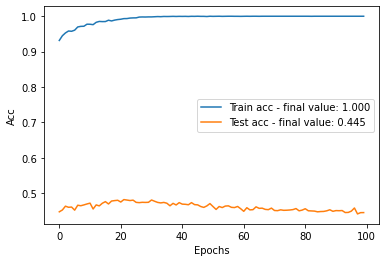

In [ ]:
acc = finetunig.history.history["acc"]; val_acc = finetunig.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


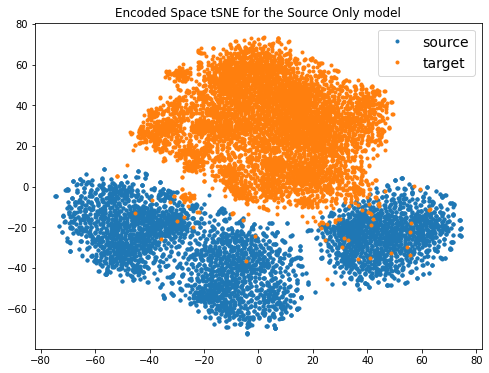

In [ ]:
LC25000_train_data_enc = finetunig.transform(LC25000_train_data_ex)
TCGA_train_data_enc = finetunig.transform(TCGA_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_ex), 0], X_tsne[:len(LC25000_train_data_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_ex):, 0], X_tsne[len(LC25000_train_data_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the Source Only model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(finetunig.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,val_loss,val_acc
count,100.000000,100.000000,100.000000,100.000000
mean,0.018270,0.993839,11.202580,0.461278
std,0.038384,0.013146,2.903152,0.010546
min,0.000002,0.931562,2.914982,0.441250
25%,0.000033,0.995430,9.932808,0.451992
50%,0.000651,0.999766,12.285906,0.460313
75%,0.011643,1.000000,13.204086,0.470625
max,0.197118,1.000000,14.168324,0.481719


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_128/MDD_source_VGG_128_RMS_0.5e-5.csv")

# Fit with adaptation

### Run 1

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr = 5e-6
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))


In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=2.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/200
100/100 [==============================] - 7s 47ms/step - loss: 0.8038 - acc: 0.7967 - disc_loss: 4.6266 - val_loss: 1.4373 - val_acc: 0.3834
Epoch 2/200
100/100 [==============================] - 4s 42ms/step - loss: 0.2486 - acc: 0.9189 - disc_loss: 3.7207 - val_loss: 1.6511 - val_acc: 0.4016
Epoch 3/200
100/100 [==============================] - 4s 42ms/step - loss: 0.2034 - acc: 0.9341 - disc_loss: 3.9038 - val_loss: 1.9366 - val_acc: 0.4308
Epoch 4/200
100/100 [==============================] - 4s 42ms/step - loss: 0.1654 - acc: 0.9503 - disc_loss: 4.8129 - val_loss: 2.6625 - val_acc: 0.4327
Epoch 5/200
100/100 [==============================] - 4s 42ms/step - loss: 0.1684 - acc: 0.9545 - disc_loss: 7.2791 - val_loss: 3.1653 - val_acc: 0.4459
Epoch 6/200
100/100 [==============================] - 4s 42ms/step - loss: 0.1771 - acc: 0.9575 - disc_loss: 12.3490 - val_loss: 4.4228 - val_acc: 0.4373
Epoch 7/200
100/100 [==============================] - 4s 42ms/step - loss:

### Run 2

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr = 5e-6
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))


In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=2.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/200
100/100 [==============================] - 11s 49ms/step - loss: 0.8038 - acc: 0.7969 - disc_loss: 4.6276 - val_loss: 1.4368 - val_acc: 0.3830
Epoch 2/200
100/100 [==============================] - 4s 43ms/step - loss: 0.2483 - acc: 0.9191 - disc_loss: 3.7167 - val_loss: 1.6566 - val_acc: 0.4002
Epoch 3/200
100/100 [==============================] - 4s 43ms/step - loss: 0.2036 - acc: 0.9341 - disc_loss: 3.9050 - val_loss: 1.9331 - val_acc: 0.4305
Epoch 4/200
100/100 [==============================] - 4s 43ms/step - loss: 0.1660 - acc: 0.9500 - disc_loss: 4.8149 - val_loss: 2.6535 - val_acc: 0.4308
Epoch 5/200
100/100 [==============================] - 4s 43ms/step - loss: 0.1681 - acc: 0.9539 - disc_loss: 7.2937 - val_loss: 3.1317 - val_acc: 0.4469
Epoch 6/200
100/100 [==============================] - 4s 43ms/step - loss: 0.1762 - acc: 0.9567 - disc_loss: 12.3427 - val_loss: 4.2472 - val_acc: 0.4391
Epoch 7/200
100/100 [==============================] - 4s 43ms/step - loss

### Run 3

In [ ]:
lr = 5e-6
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))


In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=2.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/200
100/100 [==============================] - 8s 48ms/step - loss: 0.8512 - acc: 0.7967 - disc_loss: 4.4397 - val_loss: 1.3106 - val_acc: 0.4467
Epoch 2/200
100/100 [==============================] - 4s 43ms/step - loss: 0.2348 - acc: 0.9255 - disc_loss: 3.4501 - val_loss: 1.4563 - val_acc: 0.4598
Epoch 3/200
100/100 [==============================] - 4s 43ms/step - loss: 0.1601 - acc: 0.9455 - disc_loss: 3.4750 - val_loss: 1.9243 - val_acc: 0.4481
Epoch 4/200
100/100 [==============================] - 4s 43ms/step - loss: 0.1621 - acc: 0.9509 - disc_loss: 4.1184 - val_loss: 2.5310 - val_acc: 0.4547
Epoch 5/200
100/100 [==============================] - 4s 43ms/step - loss: 0.1432 - acc: 0.9583 - disc_loss: 5.9858 - val_loss: 3.4160 - val_acc: 0.4534
Epoch 6/200
100/100 [==============================] - 4s 43ms/step - loss: 0.1784 - acc: 0.9589 - disc_loss: 11.2780 - val_loss: 4.8927 - val_acc: 0.4491
Epoch 7/200
100/100 [==============================] - 4s 43ms/step - loss:

### Run 4

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr = 5e-6
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))


In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=2.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/200
100/100 [==============================] - 8s 47ms/step - loss: 0.8038 - acc: 0.7969 - disc_loss: 4.6276 - val_loss: 1.4368 - val_acc: 0.3830
Epoch 2/200
100/100 [==============================] - 4s 43ms/step - loss: 0.2483 - acc: 0.9191 - disc_loss: 3.7167 - val_loss: 1.6566 - val_acc: 0.4002
Epoch 3/200
100/100 [==============================] - 4s 43ms/step - loss: 0.2036 - acc: 0.9341 - disc_loss: 3.9050 - val_loss: 1.9329 - val_acc: 0.4303
Epoch 4/200
100/100 [==============================] - 4s 44ms/step - loss: 0.1661 - acc: 0.9498 - disc_loss: 4.8133 - val_loss: 2.6515 - val_acc: 0.4308
Epoch 5/200
100/100 [==============================] - 4s 43ms/step - loss: 0.1676 - acc: 0.9536 - disc_loss: 7.2840 - val_loss: 3.1298 - val_acc: 0.4462
Epoch 6/200
100/100 [==============================] - 4s 43ms/step - loss: 0.1751 - acc: 0.9563 - disc_loss: 12.3654 - val_loss: 4.2483 - val_acc: 0.4414
Epoch 7/200
100/100 [==============================] - 4s 43ms/step - loss:

### Run 5

In [ ]:
lr = 5e-6
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))


In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=2.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/200
100/100 [==============================] - 8s 48ms/step - loss: 0.9574 - acc: 0.7830 - disc_loss: 4.1791 - val_loss: 1.2822 - val_acc: 0.3953
Epoch 2/200
100/100 [==============================] - 4s 43ms/step - loss: 0.2385 - acc: 0.9177 - disc_loss: 3.2368 - val_loss: 1.4886 - val_acc: 0.4298
Epoch 3/200
100/100 [==============================] - 4s 44ms/step - loss: 0.1835 - acc: 0.9389 - disc_loss: 3.3742 - val_loss: 2.0043 - val_acc: 0.4269
Epoch 4/200
100/100 [==============================] - 4s 43ms/step - loss: 0.1806 - acc: 0.9436 - disc_loss: 4.1284 - val_loss: 2.3549 - val_acc: 0.4367
Epoch 5/200
100/100 [==============================] - 4s 43ms/step - loss: 0.1845 - acc: 0.9516 - disc_loss: 6.6908 - val_loss: 2.9679 - val_acc: 0.4664
Epoch 6/200
100/100 [==============================] - 4s 43ms/step - loss: 0.2206 - acc: 0.9528 - disc_loss: 12.0113 - val_loss: 3.9943 - val_acc: 0.4747
Epoch 7/200
100/100 [==============================] - 4s 43ms/step - loss:

### Result

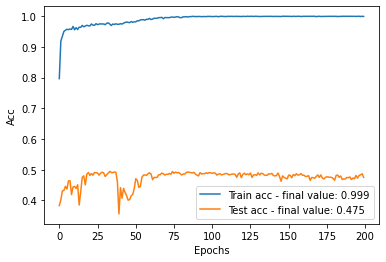

In [ ]:
acc = mdd.history.history["acc"]; val_acc = mdd.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


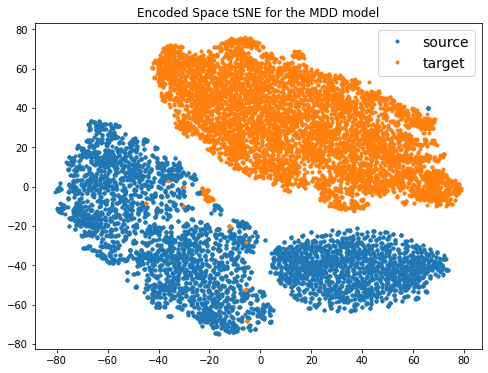

In [ ]:
LC25000_train_data_enc = mdd.transform(LC25000_train_data_ex)
TCGA_train_data_enc = mdd.transform(TCGA_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_ex), 0], X_tsne[:len(LC25000_train_data_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_ex):, 0], X_tsne[len(LC25000_train_data_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the MDD model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(mdd.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,disc_loss,val_loss,val_acc
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.043253,0.989870,16.249012,14.694591,0.474403
std,0.082767,0.019777,6.701943,4.774709,0.022763
min,0.000079,0.796719,3.042844,1.437286,0.356250
25%,0.001373,0.982578,12.456383,11.139312,0.474023
50%,0.004244,0.999062,14.447787,15.634908,0.482500
75%,0.059015,0.999570,16.690620,17.986200,0.487031
max,0.803807,1.000000,37.204525,24.856983,0.494687


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD/MDD_VGG_RMS_0.5e-5_g2.csv")